# Initialsising

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import itertools as it
import matplotlib.animation as animation
from IPython.display import HTML
from IPython.display import Image

J = -1
B = 0
k = 1
mu0 = 0.5


# Lattice Class

In [3]:
class lattice:
    def __init__(self, ndims, length, temp, lat_type): # If want non-square lattice, make length an array/tuple
        self.ndims = ndims
        self.length = length
        self.temp = temp
        # np.full creates an array of length ndims with values of length, to create the size tuple
        # Change to size=length for non-square lattice
        if type(self.length) == int:
            self.points = np.random.choice(a=[-1, 1], size=tuple(np.full(ndims, length, dtype=int)))
        elif type(self.length) == list:
            self.points = np.random.choice(a=[-1, 1], size=tuple(length))
        self.mag = 0
        self.erg = 0
        self.type = str(lat_type)
        self.update_M() # Change to product along entries of length for non-square lattice
        self.update_E()
        self.evolution = []

    def get_neighbors(self, flip_index):
        neighbors = []
        # itertools.product creates the adjacent and diagonal neighbors of any ndarray point
        for rel_pos in it.product((-1, 0, 1), repeat=self.ndims): # Loop over all neighbors. 
            # Exclude the point itself and all diagonal neighbors
            if self.type == "adj":
                if not all(i == 0 for i in rel_pos) and not all(np.abs(i) == 1 for i in rel_pos): 
                    neighbors.append(tuple((i + i_rel) for i, i_rel in zip(flip_index, rel_pos)) % np.array(self.length)) # Add neighbor spin values
            # Exclude the point itself and all adjacent neighbors
            if self.type == "diag":
                if not all(i == 0 for i in rel_pos) and all(np.abs(i) == 1 for i in rel_pos): 
                    neighbors.append(tuple((i + i_rel) for i, i_rel in zip(flip_index, rel_pos)) % np.array(self.length))
            # Exclude the point itself
            if self.type == "both":
                if not all(i == 0 for i in rel_pos):
                    neighbors.append(tuple((i + i_rel) for i, i_rel in zip(flip_index, rel_pos)) % np.array(self.length))
        neighbors = np.array(neighbors)
        return neighbors
    
    def local_E(self, flip_index):
        local_E = 0
        neighbors = self.get_neighbors(flip_index)
        for neighbor in neighbors:
            local_E += J * self.points[tuple(neighbor)] * self.points[flip_index] - mu0 * B * self.points[flip_index]
            # print(self.points[neighbor])
        # print(np.shape(local_E))
        return local_E
    
    def update_E(self):
        energy = 0
        if type(self.length) == int:
            for index in it.product(range(-1,self.length-1), repeat=self.ndims): # If want non-square lattice, make product over different ranges()
                energy += self.local_E(index) - self.points[index]*mu0*B # Add to energy
        if type(self.length) == list:
            dim_size = []
            for ii in range(len(self.length)):
                dim_size.append(range(-1,self.length[ii]-1))
            for index in it.product(*dim_size): # If want non-square lattice, make product over different ranges()
                energy += self.local_E(index) - self.points[index]*mu0*B # Add to energy
        
        self.erg = energy / 2 # divide by 2 for double-counting
        
    def update_M(self): # Update magnetization
        if type(self.length) == int:
            self.mag = np.sum(self.points) / self.length**self.ndims
        if type(self.length) == list:
            self.mag = np.sum(self.points) / np.prod(self.length)

    def set_points(self, value): # Make spins uniform for testing
        self.points = np.random.choice(a=[value], size=tuple(np.full(self.ndims, self.length, dtype=int)))

# Simulator Algorithm Class

In [22]:
class ising_algos:
    def metropolis(self, lattice, n_steps):
    # P = min(1, e^(-del_E/kT))
    # Flip always accepted if energy decreases, flip accepted with probability if energy increases
        mag = []
        erg = []
        for ii in range(0,n_steps):
            if type(lattice.length) == int:
                rand_index = tuple(np.random.choice(a=range(-1,lattice.length-1), size=lattice.ndims))
            if type(lattice.length) == list:
                dim_size = []
                for ii in range(len(lattice.length)):
                    dim_size.append(range(-1,lattice.length[ii]-1))
                lattice_points = list(it.product(*dim_size))
                rand_index = lattice_points[int(np.random.choice(a=len(lattice_points), size=1))]
            neighbors, del_E, success = self.flip(lattice, rand_index, "m")
            lattice.erg += del_E
            lattice.update_M()
            erg.append(lattice.erg)
            mag.append(lattice.mag)
            lattice.evolution.append(lattice.points)
        mag, erg = np.array(mag), np.array(erg)
        return np.array([erg, mag])
    
    
    def glauber(self, lattice, n_steps):
    # P = 1/(1+e^(del_E/kT))
    # Flips probabilistically based on energy difference
        mag = []
        erg = []
        for ii in range(0,n_steps):
            if type(lattice.length) == int:
                rand_index = tuple(np.random.choice(a=range(-1,lattice.length-1), size=lattice.ndims))
            if type(lattice.length) == list:
                dim_size = []
                for ii in range(len(lattice.length)):
                    dim_size.append(range(-1,lattice.length[ii]-1))
                lattice_points = list(it.product(*dim_size))
                rand_index = lattice_points[int(np.random.choice(a=len(lattice_points), size=1))]
            neighbors, del_E, success = self.flip(lattice, rand_index, "g")
            lattice.erg += del_E
            lattice.update_M()
            erg.append(lattice.erg)
            mag.append(lattice.mag)
        mag, erg = np.array(mag), np.array(erg)
        lattice.evolution.append(lattice.points)
        return np.array([erg, mag])
            
    
    ## DOES NOT WORK YET
    def wolff(self, lattice, n_steps, lat_type):
        mag = []
        erg = []
        for ii in range(0,n_steps):
            cluster_index = []
            checked = np.full(np.shape(lattice.points), False)
            if type(lattice.length) == int:
                rand_index = tuple(np.random.choice(a=range(-1,lattice.length-1), size=lattice.ndims))
            if type(lattice.length) == list:
                dim_size = []
                for ii in range(len(lattice.length)):
                    dim_size.append(range(-1,lattice.length[ii]-1))
                lattice_points = list(it.product(*dim_size))
                rand_index = lattice_points[np.random.choice(a=len(lattice_points), size=1)]
            self.make_cluster(lattice, rand_index, lattice.type, checked, cluster_index)
            del_E, success = self.flip_cluster(lattice, np.array(cluster_index), lat_type)
            lattice.update_M()
            erg.append(lattice.erg)
            mag.append(lattice.mag)
        mag, erg = np.array(mag), np.array(erg)
        lattice.evolution.append(lattice.points)
        return np.array([erg, mag])
    
    def flip(self, lattice, flip_index, type):
        success = True
        init_E = lattice.local_E(flip_index)
        lattice.points[flip_index] = -1 * lattice.points[flip_index]
        fin_E = lattice.local_E(flip_index)
        del_E = fin_E - init_E
        if type == "m":
            if del_E >= 0 and np.random.rand() > np.exp(-1 * del_E/(k * lattice.temp)):
                lattice.points[flip_index] = -1 * lattice.points[flip_index]
                del_E = 0
                success = False
        if type == "g":
            if np.random.rand() >= (1 / (1 + np.exp(del_E / (k*lattice.temp)))):
                lattice.points[flip_index] = -1 * lattice.points[flip_index]
                del_E = 0
                success = False
    
        return [lattice.get_neighbors(flip_index), del_E, success]
    
        ## DOES NOT WORK YET
    def make_cluster(self, lattice, flip_index, type, checked, cluster_index):
        if checked[flip_index] == True:
            pass
        else:
            neighbors = lattice.get_neighbors(flip_index)
            checked[flip_index] = True
            for neighbor in neighbors:
                if lattice.points[tuple(neighbor)] == lattice.points[flip_index]:
                    cluster_index.append(tuple(neighbor))
                    self.make_cluster(lattice, tuple(neighbor), type, checked, cluster_index)

        
    def flip_cluster(self, lattice, cluster_index, type):
        success = True
        init_E = lattice.erg
        for ii in range(0,len(cluster_index)):
            lattice.points[cluster_index[ii]] = -1 * lattice.points[cluster_index[ii]]
        lattice.update_E()
        fin_E = lattice.erg
        del_E = fin_E - init_E
        if type == "m":
            if del_E > 0 and np.random.rand() > np.exp(-1 * del_E/(k * lattice.temp)):
                for ii in range(0,len(cluster_index)):
                    lattice.points[cluster_index[ii]] = -1 * lattice.points[cluster_index[ii]]
                lattice.erg += -del_E
                success = False
        if type == "g":
            if np.random.rand() > (1 / (1 + np.exp(del_E / (k*lattice.temp)))):
                for ii in range(0,len(cluster_index)):
                    lattice.points[cluster_index[ii]] = -1 * lattice.points[cluster_index[ii]]
                lattice.erg += -del_E
                success = False

        return [del_E, success]

# Visualizer Code

In [6]:
def animate(lattice, n_steps):
    evolution_array = np.array(lattice.evolution)
    #setup figure
    fig, ax = plt.subplots()
    cmap = plt.cm.coolwarm  #colormap
    im = ax.imshow(evolution_array[0], cmap=cmap, vmin=-1, vmax=1, animated=True)
    ax.set_xticks(np.linspace(0,lattice.length,(lattice.length/2)+1))
    ax.set_yticks(np.linspace(0,lattice.length,(lattice.length/2)+1))
    #colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Spin Value")
    cbar.set_ticks([-1, 1])
    cbar.set_ticklabels(["Down (-1)", "Up (+1)"])
    #animation update
    def update(frame):
        im.set_array(evolution_array[frame])  #update lattice
        ax.set_title(f"Step {frame + 1}")  #update title
        return [im]
    #create animation
    ani = animation.FuncAnimation(fig, update, frames=n_steps, interval=100, blit=True)
    ani.save("ising_animation.gif", writer="pillow", fps=10)
    #display animation
    from IPython.display import Image
    Image("ising_animation.gif")

# Metropolis Implementation

### Adjacent Neighbors

Text(0, 0.5, 'Magnetization (something)')

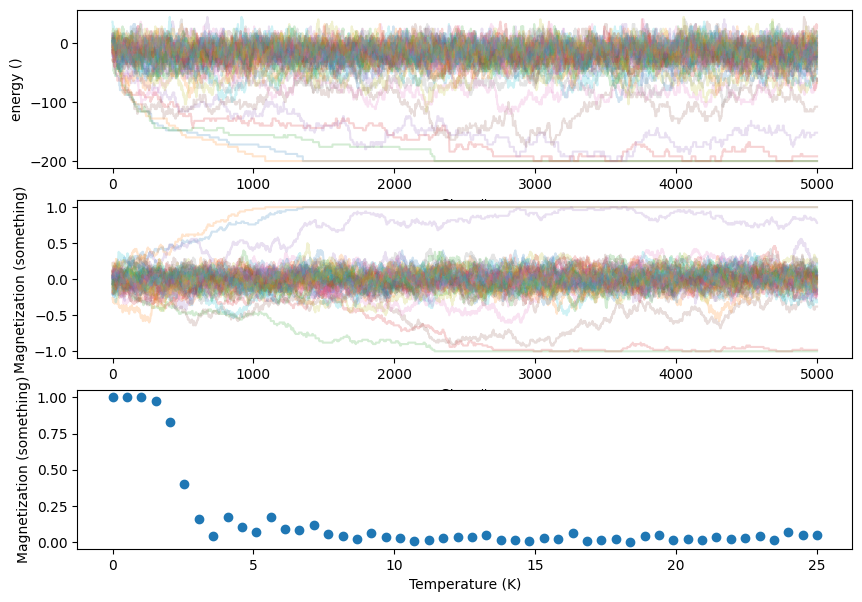

In [6]:
# Metropolis plots
temps = np.linspace(1/1e10,25,50)
mags = np.zeros(len(temps))
algo = ising_algos()
lattices = []
mag_time = []
for ii in range(0,len(temps)):
    L = lattice(2,10,temps[ii], "adj")
    lattices.append(L)

n_steps = 5000
steps = range(0,n_steps)
fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=False)
for ii in range(0,len(lattices)):
    erg, mag = algo.metropolis(lattices[ii], n_steps)
    mags[ii] = np.abs(np.average(mag[4000:]))
    mag_time.append(mag)
    ax = axes[0]
    ax.plot(steps,erg,alpha=0.2)
    ax.set_xlabel("Step #")
    ax.set_ylabel("energy ()")
    ax = axes[1]
    ax.plot(steps,mag,alpha=0.2)
    ax.set_xlabel("Step #")
    ax.set_ylabel("Magnetization (something)")

ax = axes[2]
ax.scatter(temps, mags)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Magnetization (something)")


### Diagonal Neighbors

Text(0, 0.5, 'Magnetization (something)')

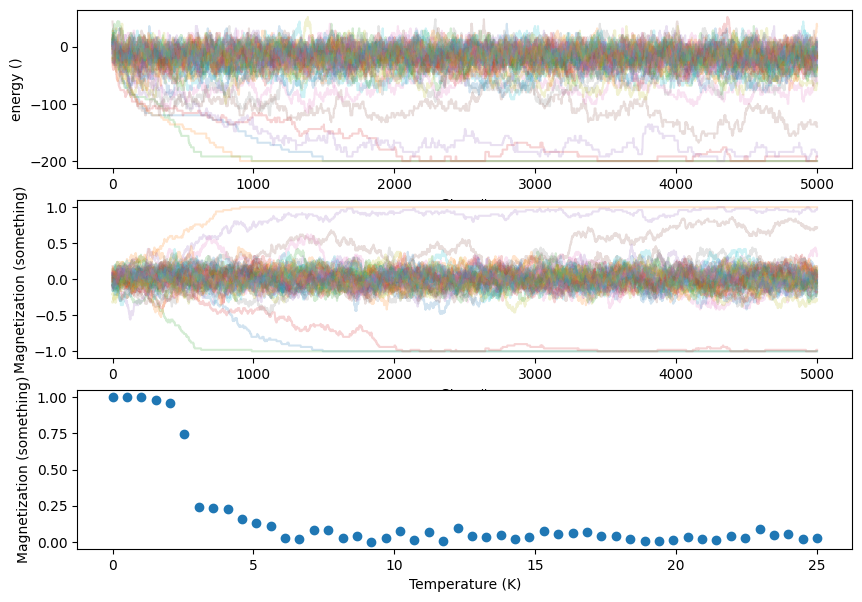

In [7]:
# Metropolis plots
temps = np.linspace(1/1e10,25,50)
mags = np.zeros(len(temps))
algo = ising_algos()
lattices = []
mag_time = []
for ii in range(0,len(temps)):
    L = lattice(2,10,temps[ii], "diag")
    lattices.append(L)

n_steps = 5000
steps = range(0,n_steps)
fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=False)
for ii in range(0,len(lattices)):
    erg, mag = algo.metropolis(lattices[ii], n_steps)
    mags[ii] = np.abs(np.average(mag[4000:]))
    mag_time.append(mag)
    ax = axes[0]
    ax.plot(steps,erg,alpha=0.2)
    ax.set_xlabel("Step #")
    ax.set_ylabel("energy ()")
    ax = axes[1]
    ax.plot(steps,mag,alpha=0.2)
    ax.set_xlabel("Step #")
    ax.set_ylabel("Magnetization (something)")

ax = axes[2]
ax.scatter(temps, mags)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Magnetization (something)")


### All Neighbors

Text(0, 0.5, 'Magnetization (something)')

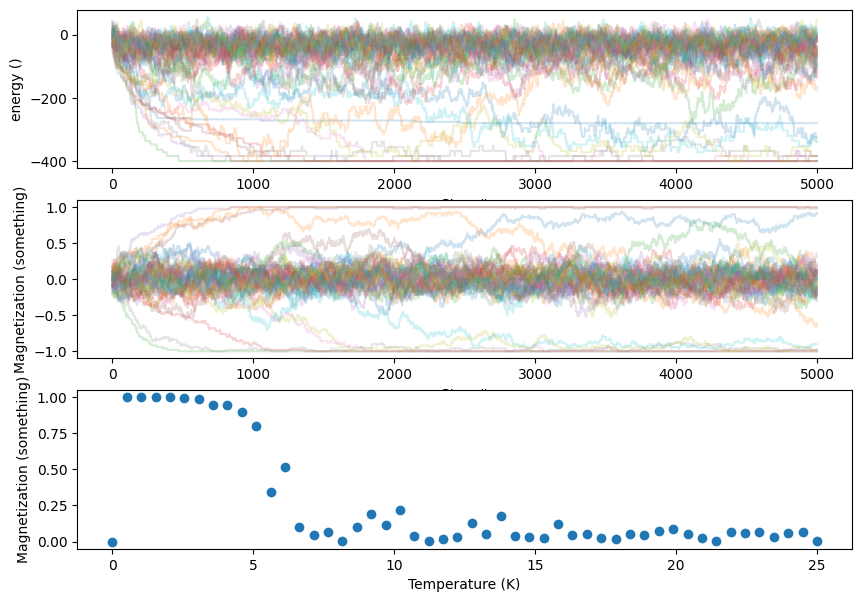

In [8]:
# Metropolis plots
temps = np.linspace(1/1e10,25,50)
mags = np.zeros(len(temps))
algo = ising_algos()
lattices = []
mag_time = []
for ii in range(0,len(temps)):
    L = lattice(2,10,temps[ii], "both")
    lattices.append(L)

n_steps = 5000
steps = range(0,n_steps)
fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=False)
for ii in range(0,len(lattices)):
    erg, mag = algo.metropolis(lattices[ii], n_steps)
    mags[ii] = np.abs(np.average(mag[4000:]))
    mag_time.append(mag)
    ax = axes[0]
    ax.plot(steps,erg,alpha=0.2)
    ax.set_xlabel("Step #")
    ax.set_ylabel("energy ()")
    ax = axes[1]
    ax.plot(steps,mag,alpha=0.2)
    ax.set_xlabel("Step #")
    ax.set_ylabel("Magnetization (something)")

ax = axes[2]
ax.scatter(temps, mags)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Magnetization (something)")


### 3D Lattice

Text(0, 0.5, 'Magnetization (something)')

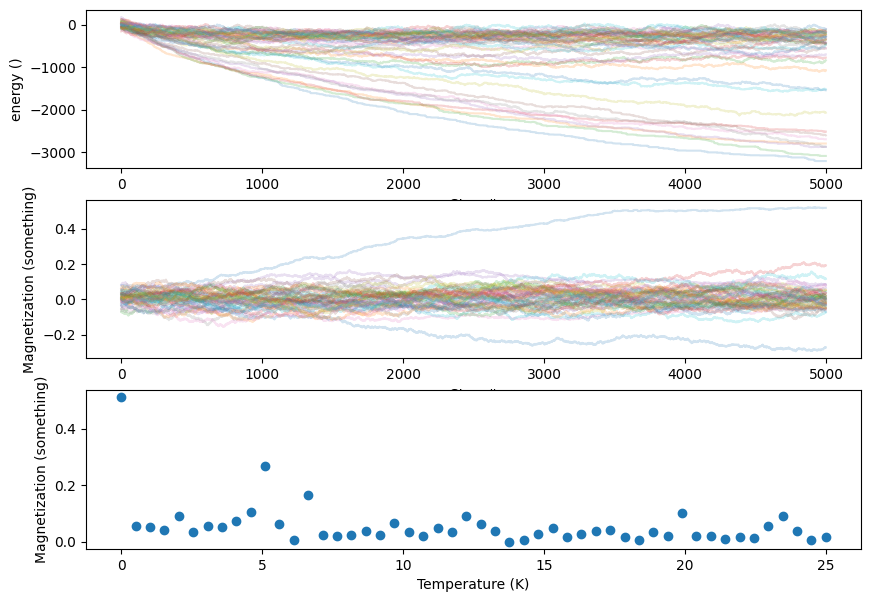

In [103]:
# Metropolis plots
temps = np.linspace(1/1e10,25,50)
mags = np.zeros(len(temps))
algo = ising_algos()
lattices = []
mag_time = []
for ii in range(0,len(temps)):
    L = lattice(3,10,temps[ii], "diag")
    lattices.append(L)

n_steps = 5000
steps = range(0,n_steps)
fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=False)
for ii in range(0,len(lattices)):
    erg, mag = algo.metropolis(lattices[ii], n_steps)
    mags[ii] = np.abs(np.average(mag[4000:]))
    mag_time.append(mag)
    ax = axes[0]
    ax.plot(steps,erg,alpha=0.2)
    ax.set_xlabel("Step #")
    ax.set_ylabel("energy ()")
    ax = axes[1]
    ax.plot(steps,mag,alpha=0.2)
    ax.set_xlabel("Step #")
    ax.set_ylabel("Magnetization (something)")

ax = axes[2]
ax.scatter(temps, mags)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Magnetization (something)")


### Rectangular Lattice

/tmp/ipykernel_72408/2759651304.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rand_index = lattice_points[int(np.random.choice(a=len(lattice_points), size=1))]


Text(0, 0.5, 'Magnetization (something)')

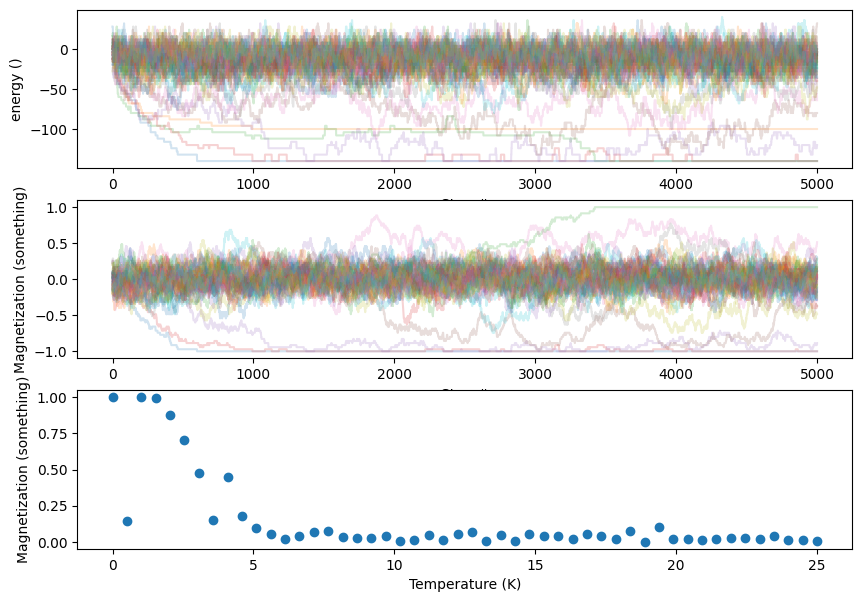

In [102]:
# Metropolis plots
temps = np.linspace(1/1e10,25,50)
mags = np.zeros(len(temps))
algo = ising_algos()
lattices = []
mag_time = []
for ii in range(0,len(temps)):
    L = lattice(2,[7,10],temps[ii], "adj")
    lattices.append(L)

n_steps = 5000
steps = range(0,n_steps)
fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=False)
for ii in range(0,len(lattices)):
    erg, mag = algo.metropolis(lattices[ii], n_steps)
    mags[ii] = np.abs(np.average(mag[4000:]))
    mag_time.append(mag)
    ax = axes[0]
    ax.plot(steps,erg,alpha=0.2)
    ax.set_xlabel("Step #")
    ax.set_ylabel("energy ()")
    ax = axes[1]
    ax.plot(steps,mag,alpha=0.2)
    ax.set_xlabel("Step #")
    ax.set_ylabel("Magnetization (something)")

ax = axes[2]
ax.scatter(temps, mags)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Magnetization (something)")


# Glauber Implementation

### Adjacent Neighbors

/tmp/ipykernel_1490/2433783786.py:66: RuntimeWarning: overflow encountered in exp
  if np.random.rand() >= (1 / (1 + np.exp(del_E / (k*lattice.temp)))):


Text(0, 0.5, 'Magnetization (something)')

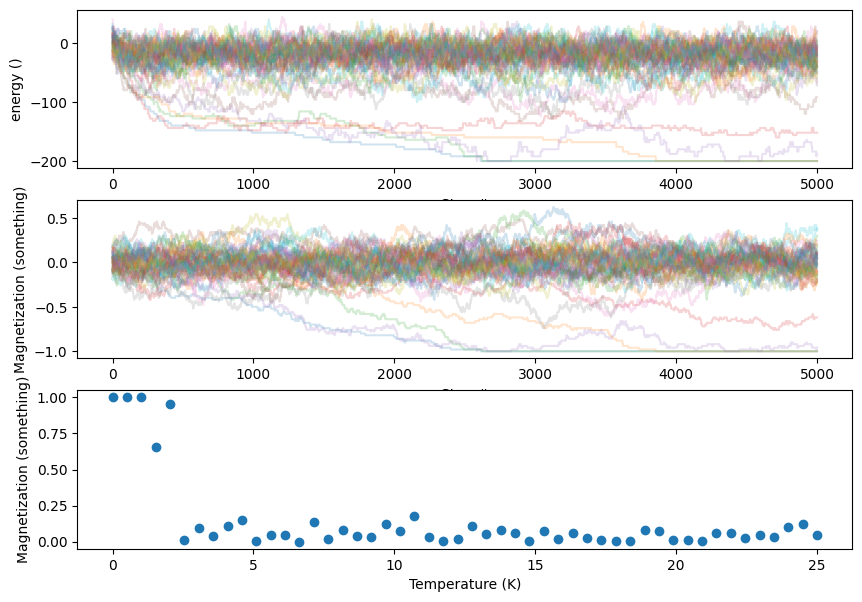

In [9]:
# Glauber plots
temps = np.linspace(1/1e10,25,50)
mags = np.zeros(len(temps))
algo = ising_algos()
lattices = []
for ii in range(0,len(temps)):
    L = lattice(2,10,temps[ii], "adj")
    lattices.append(L)

n_steps = 5000
steps = range(0,n_steps)
fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=False)
for ii in range(0,len(lattices)):
    erg, mag = algo.glauber(lattices[ii], n_steps)
    mags[ii] = np.abs(np.average(mag[4000:]))
    ax = axes[0]
    ax.plot(steps,erg,alpha=0.2)
    ax.set_xlabel("Step #")
    ax.set_ylabel("energy ()")
    ax = axes[1]
    ax.plot(steps,mag,alpha=0.2)
    ax.set_xlabel("Step #")
    ax.set_ylabel("Magnetization (something)")

ax = axes[2]
ax.scatter(temps, mags)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Magnetization (something)")


### Diagonal Neighbors

/tmp/ipykernel_1490/2433783786.py:66: RuntimeWarning: overflow encountered in exp
  if np.random.rand() >= (1 / (1 + np.exp(del_E / (k*lattice.temp)))):


Text(0, 0.5, 'Magnetization (something)')

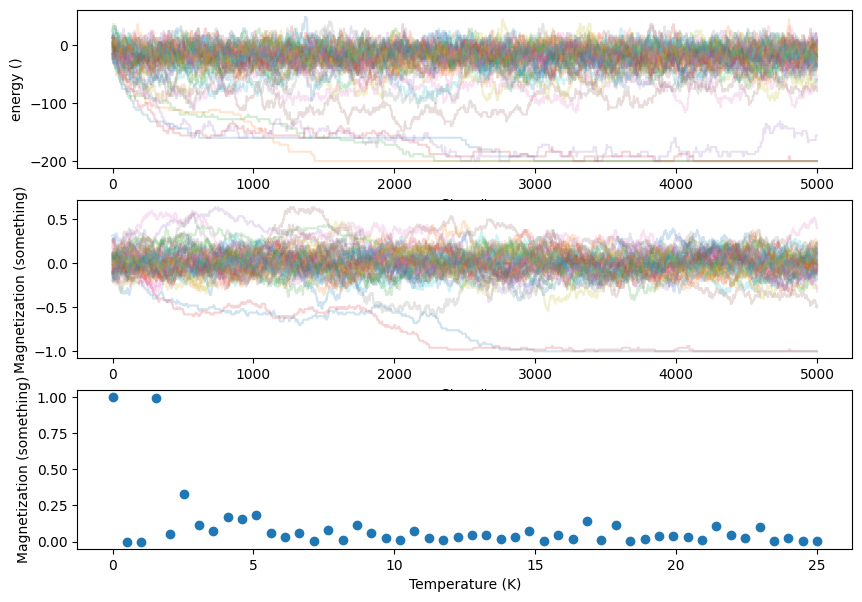

In [10]:
# Glauber plots
temps = np.linspace(1/1e10,25,50)
mags = np.zeros(len(temps))
algo = ising_algos()
lattices = []
for ii in range(0,len(temps)):
    L = lattice(2,10,temps[ii], "diag")
    lattices.append(L)

n_steps = 5000
steps = range(0,n_steps)
fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=False)
for ii in range(0,len(lattices)):
    erg, mag = algo.glauber(lattices[ii], n_steps)
    mags[ii] = np.abs(np.average(mag[4000:]))
    ax = axes[0]
    ax.plot(steps,erg,alpha=0.2)
    ax.set_xlabel("Step #")
    ax.set_ylabel("energy ()")
    ax = axes[1]
    ax.plot(steps,mag,alpha=0.2)
    ax.set_xlabel("Step #")
    ax.set_ylabel("Magnetization (something)")

ax = axes[2]
ax.scatter(temps, mags)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Magnetization (something)")


### All Neighbors

/tmp/ipykernel_1490/2433783786.py:66: RuntimeWarning: overflow encountered in exp
  if np.random.rand() >= (1 / (1 + np.exp(del_E / (k*lattice.temp)))):


Text(0, 0.5, 'Magnetization (something)')

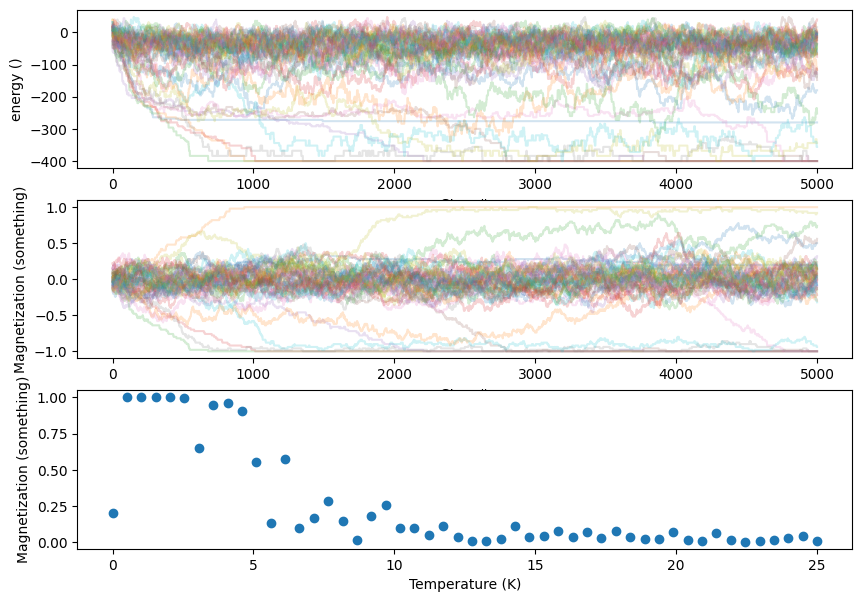

In [11]:
# Glauber plots
temps = np.linspace(1/1e10,25,50)
mags = np.zeros(len(temps))
algo = ising_algos()
lattices = []
for ii in range(0,len(temps)):
    L = lattice(2,10,temps[ii], "both")
    lattices.append(L)

n_steps = 5000
steps = range(0,n_steps)
fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=False)
for ii in range(0,len(lattices)):
    erg, mag = algo.glauber(lattices[ii], n_steps)
    mags[ii] = np.abs(np.average(mag[4000:]))
    ax = axes[0]
    ax.plot(steps,erg,alpha=0.2)
    ax.set_xlabel("Step #")
    ax.set_ylabel("energy ()")
    ax = axes[1]
    ax.plot(steps,mag,alpha=0.2)
    ax.set_xlabel("Step #")
    ax.set_ylabel("Magnetization (something)")

ax = axes[2]
ax.scatter(temps, mags)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Magnetization (something)")


### 3D Lattice

Text(0, 0.5, 'Magnetization (something)')

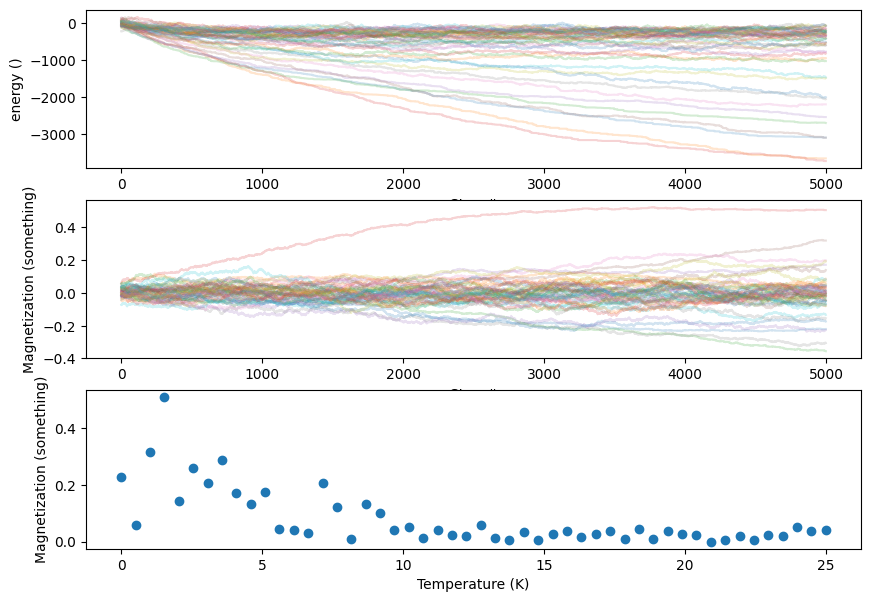

In [7]:
# Glauber plots
temps = np.linspace(1/1e10,25,50)
mags = np.zeros(len(temps))
algo = ising_algos()
lattices = []
mag_time = []
for ii in range(0,len(temps)):
    L = lattice(3,10,temps[ii], "diag")
    lattices.append(L)

n_steps = 5000
steps = range(0,n_steps)
fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=False)
for ii in range(0,len(lattices)):
    erg, mag = algo.metropolis(lattices[ii], n_steps)
    mags[ii] = np.abs(np.average(mag[4000:]))
    mag_time.append(mag)
    ax = axes[0]
    ax.plot(steps,erg,alpha=0.2)
    ax.set_xlabel("Step #")
    ax.set_ylabel("energy ()")
    ax = axes[1]
    ax.plot(steps,mag,alpha=0.2)
    ax.set_xlabel("Step #")
    ax.set_ylabel("Magnetization (something)")

ax = axes[2]
ax.scatter(temps, mags)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Magnetization (something)")


### Rectangular Lattice

/tmp/ipykernel_72408/2759651304.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rand_index = lattice_points[int(np.random.choice(a=len(lattice_points), size=1))]


Text(0, 0.5, 'Magnetization (something)')

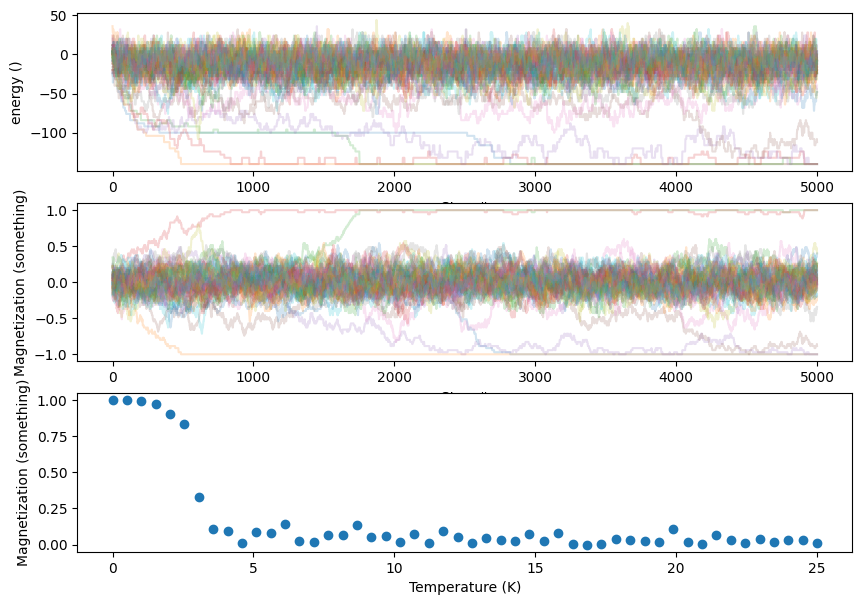

In [105]:
# Glauber plots
temps = np.linspace(1/1e10,25,50)
mags = np.zeros(len(temps))
algo = ising_algos()
lattices = []
mag_time = []
for ii in range(0,len(temps)):
    L = lattice(2,[7,10],temps[ii], "diag")
    lattices.append(L)

n_steps = 5000
steps = range(0,n_steps)
fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=False)
for ii in range(0,len(lattices)):
    erg, mag = algo.metropolis(lattices[ii], n_steps)
    mags[ii] = np.abs(np.average(mag[4000:]))
    mag_time.append(mag)
    ax = axes[0]
    ax.plot(steps,erg,alpha=0.2)
    ax.set_xlabel("Step #")
    ax.set_ylabel("energy ()")
    ax = axes[1]
    ax.plot(steps,mag,alpha=0.2)
    ax.set_xlabel("Step #")
    ax.set_ylabel("Magnetization (something)")

ax = axes[2]
ax.scatter(temps, mags)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Magnetization (something)")


# Wolff Implementation

Text(0, 0.5, 'Magnetization (something)')

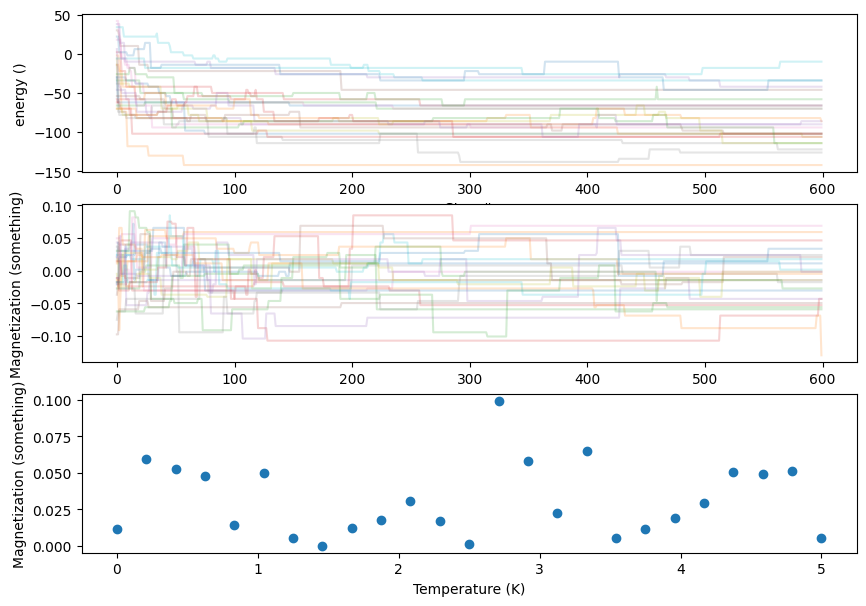

In [23]:
# Wolff plots
temps = np.linspace(1/1e10,5,25)
mags = np.zeros(len(temps))
algo = ising_algos()
lattices = []
for ii in range(0,len(temps)):
    L = lattice(2,25,temps[ii], "adj")
    lattices.append(L)

n_steps = 600
steps = range(0,n_steps)
fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=False)
progress = 0
for ii in range(0,len(lattices)):
    erg, mag = algo.wolff(lattices[ii], n_steps, "m")
    mags[ii] = np.abs(np.average(mag[180:]))
    ax = axes[0]
    ax.plot(steps,erg,alpha=0.2)
    ax.set_xlabel("Step #")
    ax.set_ylabel("energy ()")
    ax = axes[1]
    ax.plot(steps,mag,alpha=0.2)
    ax.set_xlabel("Step #")
    ax.set_ylabel("Magnetization (something)")

    progress += 1
    print("Completed lattices: " + str(progress), end='\r', flush=True)

ax = axes[2]
ax.scatter(temps, mags)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Magnetization (something)")


/tmp/ipykernel_27370/3194608940.py:102: RuntimeWarning: overflow encountered in exp
  if np.random.rand() >= (1 / (1 + np.exp(del_E / (k*lattice.temp)))):


Text(0, 0.5, 'Magnetization (something)')

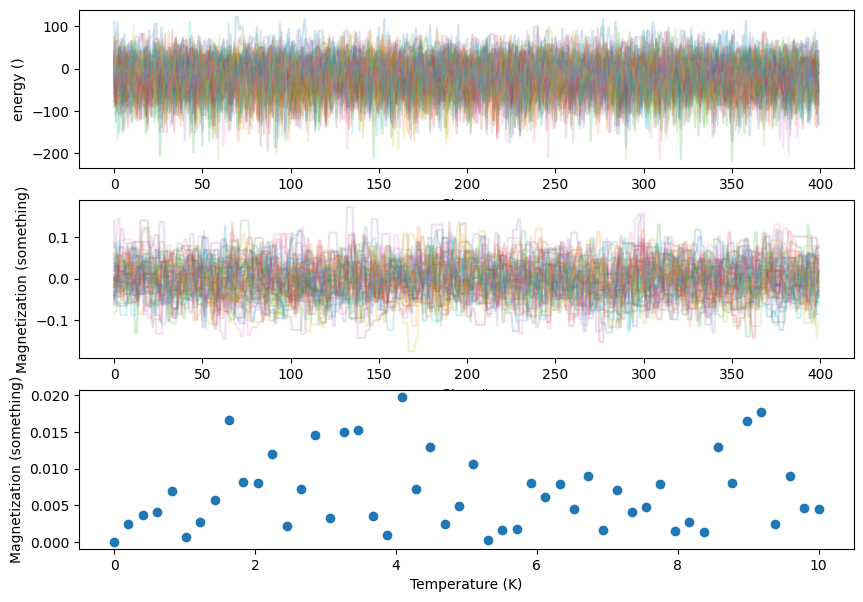

In [12]:
# Wolff plots
temps = np.linspace(1/1e10,10,50)
mags = np.zeros(len(temps))
algo = ising_algos()
lattices = []
for ii in range(0,len(temps)):
    L = lattice(2,25,temps[ii], "adj")
    lattices.append(L)

n_steps = 400
steps = range(0,n_steps)
fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=False)
progress = 0
for ii in range(0,len(lattices)):
    erg, mag = algo.wolff(lattices[ii], n_steps, "g")
    mags[ii] = np.abs(np.average(mag[180:]))
    ax = axes[0]
    ax.plot(steps,erg,alpha=0.2)
    ax.set_xlabel("Step #")
    ax.set_ylabel("energy ()")
    ax = axes[1]
    ax.plot(steps,mag,alpha=0.2)
    ax.set_xlabel("Step #")
    ax.set_ylabel("Magnetization (something)")

    progress += 1
    print("Completed lattices: " + str(progress), end='\r', flush=True)

ax = axes[2]
ax.scatter(temps, mags)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Magnetization (something)")
